### This file is meant to preprocess the mgf data for contrastive fine-tuning

In [1]:
from dreams.utils.data import MSData, evaluate_split
import numpy as np
import pandas as pd
from dreams.api import dreams_embeddings
from sklearn.metrics.pairwise import cosine_similarity
import umap
from dreams.utils.mols import formula_type
import seaborn as sns
import matplotlib.pyplot as plt
from dreams.utils.plots import init_plotting
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from rdkit import Chem

In [2]:
data_full = MSData('data/mgf_MoNA_experimental.hdf5')
print(data_full)
print(data_full.columns())

MSData(pth=data\mgf_MoNA_experimental.hdf5, in_mem=False) with 167,958 spectra.
['EXACTMASS', 'FORMULA', 'INCHIKEY', 'INSTRUMENT_TYPE', 'IONMODE', 'NAME', 'RTINSECONDS', 'SOURCE_INSTRUMENT', 'SPECTRUM_TYPE', 'charge', 'precursor_mz', 'smiles', 'spectrum']


### Quality processing:
- rename to NIST name format
- filter by [M+H]+ charge as mentioned in paper
- remove spectra with invalid smiles
- add mol notation
- apply A quality conditions (add MSnSpectra column)

From 167k to 67k spectra

In [3]:
# convert to pandas
df = data_full.to_pandas()

# convert to NIST format
df.rename(columns={'charge': 'CHARGE', 'precursor_mz': 'PRECURSOR M/Z', 'smiles': 'SMILES', 'spectrum': 'PARSED PEAKS'}, inplace=True)
# only select the spectra with [M+H]+ adducts
df = df[df['CHARGE'] == "[M+H]+"]
# remove spectra if smiles is n/a or if the smiles is not a valid molecule, also add RoMol column
df = df[df['SMILES'] != 'n/a']
df = df[df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]
df["ROMol"] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# convert to A format adds MSnSpectra column among other quality conditions
from dreams.utils.dformats import to_A_format
df = to_A_format(df, reset_index=False, filter=False)

[11:26:25] Explicit valence for atom # 0 Be, 4, is greater than permitted
[11:26:25] Explicit valence for atom # 0 Be, 4, is greater than permitted
[11:26:29] Explicit valence for atom # 19 N, 4, is greater than permitted
[11:26:29] Explicit valence for atom # 17 N, 4, is greater than permitted
[11:26:29] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[11:26:29] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
[11:26:30] SMILES Parse Error: syntax error while parsing: N/ACCC1(C(=O)NCNC1=O)c2ccccc2
[11:26:30] SMILES Parse Error: Failed parsing SMILES 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2' for input: 'N/ACCC1(C(=O)NCNC1=O)c2ccccc2'


### Create contrastive dataset:
- subsample to n_samples total samples and n_inchi_prefix unique inchikey prefixes
- for each spectra, determine positive and negative examples and store indices

In [4]:
n_inchi_prefix = 2250
n_samples = 12500

# get the 14 character prefix of inchikey
df["INCHI_PREFIX"] = df["INCHIKEY"].apply(lambda x: x[:14])

# ensure only n_inchi_prefix unique INCHI_PREFIX values
unique_inchi_prefixes = df.drop_duplicates(subset=["INCHI_PREFIX"]).head(n_inchi_prefix)["INCHI_PREFIX"]

# filter the DataFrame to include only rows with these n_inchi_prefix unique INCHI_PREFIX values
filtered_df = df[df["INCHI_PREFIX"].isin(unique_inchi_prefixes)]

# randomly sample n_samples rows from the filtered DataFrame
df = filtered_df.sample(n=n_samples, random_state=1)

In [5]:
# # Initialize lists to store positive and negative indices
pos_idx = []
neg_idx = []

# Define mass tolerance
mass_tolerance = 0.2

# Find positive and negative examples for each spectrum
for idx, row in df.iterrows():
    # Find positive examples
    pos = df[df["INCHI_PREFIX"] == row["INCHI_PREFIX"]].index.tolist()
    # keep the same index if only one positive example is found
    if len(pos) > 1:
        pos.remove(idx)
    pos_idx.append(pos)
    
    # Find negative examples
    neg = df[(df["EXACTMASS"].between(row["EXACTMASS"] - mass_tolerance, row["EXACTMASS"] + mass_tolerance)) & (df["INCHI_PREFIX"] != row["INCHI_PREFIX"])].index.tolist()
    # if we dont fine any, add the 5 spectra with the smallest difference in exact mass
    if len(neg) == 0:
        neg = df[(df["INCHI_PREFIX"] != row["INCHI_PREFIX"])].sort_values(by="EXACTMASS", key=lambda x: np.abs(x - row["EXACTMASS"])).head(5).index.tolist()
    neg_idx.append(neg)

# Add positive and negative indices as new columns in the DataFrame
df["pos_idx"] = pos_idx
df["neg_idx"] = neg_idx

### Create Murcko histogram split according to https://github.com/pluskal-lab/DreaMS/blob/main/tutorials/murcko_hist_split.ipynb

In [7]:
from dreams.algorithms.murcko_hist import murcko_hist
# some smiles are invalid?
def is_valid_smiles(smiles):
    if pd.isna(smiles) or smiles == 'n/a':
        return False
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None


# Compute Murcko histograms

df_us = df.drop_duplicates(subset=['SMILES']).copy()
df_us = df.copy()
df_us['MurckoHist'] = df['SMILES'].progress_apply(
    lambda x: murcko_hist.murcko_hist(Chem.MolFromSmiles(x))
)

# Convert dictionaries to strings for easier handling
df_us['MurckoHistStr'] = df_us['MurckoHist'].astype(str)
print('Num. unique smiles:', df_us['SMILES'].nunique(), 'Num. unique Murcko histograms:', df_us['MurckoHistStr'].nunique())
print('Top 20 most common Murcko histograms:')
df_us['MurckoHistStr'].value_counts()[:20]

# Group by MurckoHistStr and aggregate
df_gb = df_us.groupby('MurckoHistStr').agg(
    count=('SMILES', 'count'),
    smiles_list=('SMILES', list)
).reset_index()

# Convert MurckoHistStr to MurckoHist
df_gb['MurckoHist'] = df_gb['MurckoHistStr'].apply(eval)

# Sort by 'n' in descending order and reset index
df_gb = df_gb.sort_values('count', ascending=False).reset_index(drop=True)

100%|██████████| 12500/12500 [00:08<00:00, 1473.88it/s]

Num. unique smiles: 4432 Num. unique Murcko histograms: 153
Top 20 most common Murcko histograms:


In [8]:
#Split the dataset into training and validation sets based on Murcko histograms

median_i = len(df_gb) // 2
cum_val_mols = 0
val_mols_frac = 0.15  # Approximately 15% of the molecules go to validation set
val_idx, train_idx = [], []

# Iterate from median to start, assigning molecules to train or val sets
for i in range(median_i, -1, -1):
    current_hist = df_gb.iloc[i]['MurckoHist']
    is_val_subhist = any(
        murcko_hist.are_sub_hists(current_hist, df_gb.iloc[j]['MurckoHist'], k=3, d=4)
        for j in val_idx
    )

    if is_val_subhist:
        train_idx.append(i)
    else:
        if cum_val_mols / len(df_us) <= val_mols_frac:
            cum_val_mols += df_gb.iloc[i]['count']
            val_idx.append(i)
        else:
            train_idx.append(i)

# Add remaining indices to train set
train_idx.extend(range(median_i + 1, len(df_gb)))
assert(len(train_idx) + len(val_idx) == len(df_gb))

# Map SMILES to their assigned fold
smiles_to_fold = {}
for i, row in df_gb.iterrows():
    fold = 'val' if i in val_idx else 'train'
    for smiles in row['smiles_list']:
        smiles_to_fold[smiles] = fold
df['fold'] = df['SMILES'].map(smiles_to_fold)

# Display fold distributions
print('Distribution of spectra:')
display(df['fold'].value_counts(normalize=True))
print('Distribution of smiles:')
display(df.drop_duplicates(subset=['SMILES'])['fold'].value_counts(normalize=True))

Distribution of spectra:


fold
train    0.80296
val      0.19704
Name: proportion, dtype: float64

Distribution of smiles:


fold
train    0.797834
val      0.202166
Name: proportion, dtype: float64

100%|██████████| 896/896 [00:00<00:00, 5564.37it/s]


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


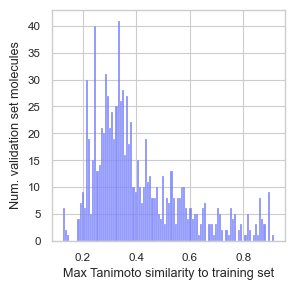

In [10]:
# Evaluate data leakage
eval_res = evaluate_split(df, n_workers=4, smiles_col="SMILES")
init_plotting(figsize=(3, 3))
sns.histplot(eval_res['val'], bins=100)
plt.xlabel('Max Tanimoto similarity to training set')
plt.ylabel('Num. validation set molecules')
plt.show()

In [11]:
# Store the dataset to pickle (required by train.py)
df.to_pickle(f'data/MoNA_experimental_contrastive.pkl')

### Contrastive fine-tuning

In [ ]:
#!python dreams/training/train.py --num_workers_data 12 --no_wandb --project_name "dreams-contrastive" --job_key "default" --run_name "default" --train_objective "contrastive_spec_embs" --train_regime "fine-tuning" --dataset_pth "data/MoNA_experimental_contrastive.pkl" --dformat A --model DreaMS --lr 3e-5 --batch_size 4 --prec_intens 1.1 --num_devices 8 --max_epochs 10 --log_every_n_steps 5 --head_depth 1 --seed 3407 --train_precision 32   --pre_trained_pth "dreams/models/pretrained/ssl_model.ckpt" --val_check_interval 0.1 --max_peaks_n 100 --save_top_k -1

### Steps after training:
1. generate embeddings with finetuned model
2. calculate novelty as inverse cosine similarity
3. plot umap and compare with non finetuned version